# Acknowledgements
code in part inspired by: https://github.com/EthanRosenthal/torchmf

# Imports

In [33]:
import os
import mxnet as mx
from mxnet import gluon, nd, ndarray

import pandas as pd
import numpy as np
import multiprocessing

# Parameters

In [34]:
data_path = '/tmp/ml-100k/'
prefix='ml-100k'
num_emb = 64
# Improvement 1: Each record is only 3 float32. Batch size can be increased up to the size of the 
# dataset and still take only 1.5 Gb of GPU memory including the model itself
batch_size = 80000
# ctx = mx.gpu()
ctx = mx.cpu()

# Download and Unpack Dataset

In [35]:
def download_ml_data(prefix, os_path):
    if not os.path.exists(os_path+"%s.zip" % prefix):
        print("Downloading MovieLens data: %s" % prefix)
        os.system("wget http://files.grouplens.org/datasets/movielens/{}.zip -P {}".format(prefix, data_path))
    print("unzip {}{}.zip -d {}".format(data_path,prefix, data_path))
    os.system("unzip {}{}.zip -d {}".format(data_path,prefix, data_path))   


download_ml_data(prefix=prefix, os_path=data_path)

unzip /tmp/ml-100k/ml-100k.zip -d /tmp/ml-100k/


# Finding Max UserID and Max ItemID

In [36]:
def max_id(fname):
    mu = 0
    mi = 0
    with open(fname) as f:
        for line in f:
            tks = line.strip().split('\t')
            if len(tks) != 4:
                continue
            mu = max(mu, int(tks[0]))
            mi = max(mi, int(tks[1]))
    return mu + 1, mi + 1
max_users, max_items = max_id(data_path + prefix  +'/u.data')
(max_users, max_items)

(944, 1683)

# Converting Data to NDArray

In [37]:
train_df = pd.read_csv(data_path + prefix + '/u1.base', header=None, sep='\t')
test_df = pd.read_csv(data_path + prefix + '/u1.test', header=None, sep='\t')
print(train_df[0:5])
train_data = nd.array(train_df[[0,1]].values, dtype=np.float32)
train_label = nd.array(train_df[2].values, dtype=np.float32)

test_data = nd.array(test_df[[0,1]].values, dtype=np.float32)
test_label = nd.array(test_df[2].values, dtype=np.float32)
(train_data[0:5], train_label[0:5])

   0  1  2          3
0  1  1  5  874965758
1  1  2  3  876893171
2  1  3  4  878542960
3  1  4  3  876893119
4  1  5  3  889751712


(
 [[1. 1.]
  [1. 2.]
  [1. 3.]
  [1. 4.]
  [1. 5.]]
 <NDArray 5x2 @cpu(0)>, 
 [5. 3. 4. 3. 3.]
 <NDArray 5 @cpu(0)>)

# Creating Dataset

In [38]:
# Improvement 2: Dataset inherits from ArrayDataset and ready for being loaded 
class SparseMatrixDataset(gluon.data.ArrayDataset):
        def __init__(self, data, label):
            records = []

            for i, (data, label) in enumerate(zip(train_data, train_label)):
                records.append((data[0], data[1], label))
                
            super(SparseMatrixDataset, self).__init__(records)

# Defining the Network

In [39]:
class MFBlock(gluon.HybridBlock):
    def __init__(self, max_users, max_items, num_emb, dropout_p=0.5):
        super(MFBlock, self).__init__()
        
        self.max_users = max_users
        self.max_items = max_items
        self.dropout_p = dropout_p
        self.num_emb = num_emb
        
        with self.name_scope():
            self.user_embeddings = gluon.nn.Embedding(max_users, num_emb)
            self.item_embeddings = gluon.nn.Embedding(max_items, num_emb)
            self.dropout = gluon.nn.Dropout(dropout_p)
            self.dense = gluon.nn.Dense(num_emb, activation='relu')
            
    def hybrid_forward(self, F, users, items):
        a = self.user_embeddings(users)
        a = self.dense(a)
        
        b = self.item_embeddings(items)
        b = self.dense(b)

        predictions = self.dropout(a) * self.dropout(b)      
        predictions = F.sum(predictions, axis=1)
        return predictions

        

# Creating Network

In [40]:
net = MFBlock(max_users=max_users, max_items=max_items, num_emb=num_emb, dropout_p=0.)
net.collect_params()

mfblock4_ (
  Parameter mfblock4_embedding0_weight (shape=(944, 64), dtype=float32)
  Parameter mfblock4_embedding1_weight (shape=(1683, 64), dtype=float32)
  Parameter mfblock4_dense0_weight (shape=(64, 0), dtype=float32)
  Parameter mfblock4_dense0_bias (shape=(64,), dtype=float32)
)

In [41]:
# Improvement 3: Use new batch_size
mx.sym.var(name='test', shape=(batch_size,2))

<Symbol test>

In [42]:
input_sym1 = mx.sym.var('user')
input_sym2 = mx.sym.var('item')

In [43]:
output_sym = net(input_sym1, input_sym2)

/Users/sssokolo/anaconda3/lib/python3.6/site-packages/mxnet/visualization.py:292: RuntimeWarning: There are multiple variables with the same name in your graph, this may result in cyclic graph. Repeated names: mfblock4_dropout0_fwd,mfblock4_dense0_fwd,mfblock4_dense0_relu_fwd
  warnings.warn(warning_message, RuntimeWarning)


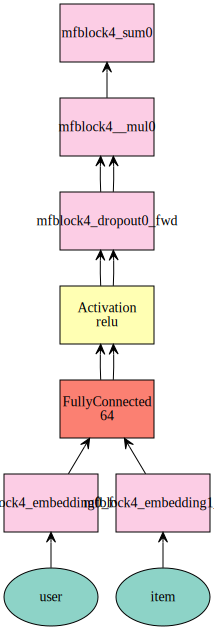

In [44]:
mx.viz.plot_network(output_sym, )

In [45]:
net = MFBlock(max_users=max_users, max_items=max_items, num_emb=num_emb, dropout_p=0.)
net.initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx, force_reinit=True)
net.summary(mx.nd.random.uniform(shape=(batch_size, 1), ctx=ctx), mx.nd.random.uniform(shape=(batch_size, 1), ctx=ctx))

# Improvement 4: Hybridize network
net.hybridize(static_alloc=True)

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                      (80000, 1), (80000, 1)               0
         Embedding-1                              (80000, 1, 64)           60416
        Activation-2           <Symbol mfblock5_dense0_relu_fwd>               0
        Activation-3                                 (80000, 64)               0
             Dense-4                                 (80000, 64)            4160
         Embedding-5                              (80000, 1, 64)          107712
        Activation-6                                 (80000, 64)               0
             Dense-7                                 (80000, 64)            4160
           Dropout-8                                 (80000, 64)               0
           Dropout-9                                 (80000, 64)               0
          MFBlock-10        

# Loss Function

In [46]:
loss_function = gluon.loss.L2Loss()

# Optimizer

In [47]:
# Improvement 5: Use different optimizer
trainer = gluon.Trainer(net.collect_params(), 'ftml', {'learning_rate': 0.03 })

In [48]:
train_dataset = SparseMatrixDataset(train_data, train_label)
test_dataset = SparseMatrixDataset(test_data, test_label)

# Improvement 6: Increase number of workers. Don't need to much though
train_data_iter = gluon.data.DataLoader(train_dataset, 
                                        shuffle=True, batch_size=batch_size, num_workers=2)
test_data_iter = gluon.data.DataLoader(test_dataset,
                                          shuffle=True, batch_size=batch_size, num_workers=2)

# Network Evaluator

In [49]:
def eval_net(data, net):
    accs = [mx.metric.RMSE(), mx.metric.Accuracy()]
    acc = mx.metric.CompositeEvalMetric()
    
    for i in accs:
        acc.add(i)
        
    for i, (user, item, label) in enumerate(data):
        user = user.as_in_context(ctx).reshape((user.shape[0],))
        item = item.as_in_context(ctx).reshape((user.shape[0],))
        label = label.as_in_context(ctx).reshape((user.shape[0],))
        predictions = net(user, item)
        acc.update(preds=predictions, labels=label)
    return acc

# Training

In [50]:
epochs = 30
#smoothing_constant = 10

def train(data_iter, net):
    for e in range(epochs):
        for i, (user, item, label) in enumerate(train_data_iter):
            user = user.as_in_context(ctx).reshape((user.shape[0],))
            item = item.as_in_context(ctx).reshape((user.shape[0],))
            label = label.as_in_context(ctx).reshape((user.shape[0],))
            
            with mx.autograd.record():
                output = net(user, item)               
                loss = loss_function(output, label)
            
            loss.backward()
            trainer.step(user.shape[0])
            
        print("EPOCH {}: RMSE ON TRAINING and TEST: {}. {}".format(e,
                                                                   eval_net(train_data_iter, net),
                                                                   eval_net(test_data_iter, net)))
    return "end of training"

In [ ]:
train(train_data_iter, net)